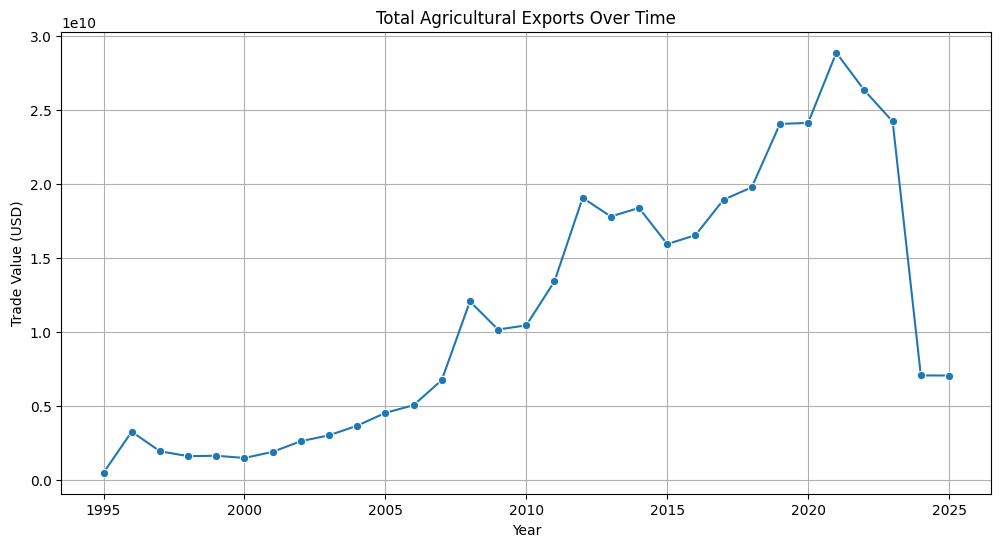

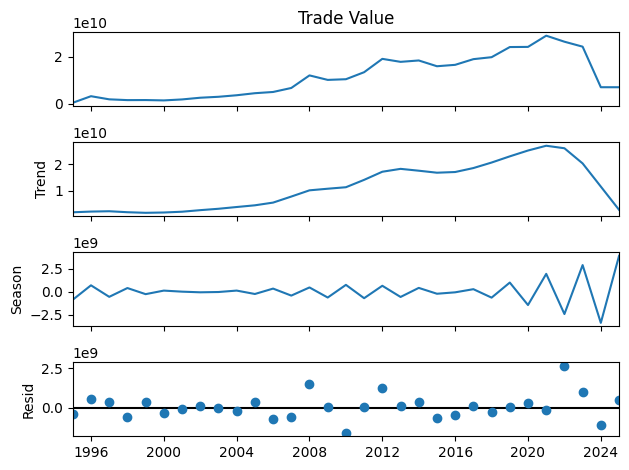

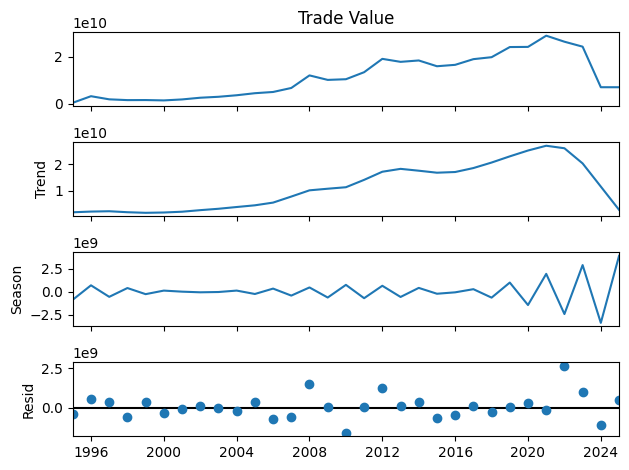

In [49]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# 2. Load the dataset
# Assuming you saved your CSV as 'agricultural_exports.csv'
df = pd.read_csv('/Users/sandra/Desktop/UCU/hakathon/agriculture-losses/algorithm/agricultural_exports_combined.csv')

# 3. Aggregate total trade value per year
yearly_exports = df.groupby('Year')['Trade Value'].sum()

# 4. Visualize the total exports over time
plt.figure(figsize=(12,6))
sns.lineplot(x=yearly_exports.index, y=yearly_exports.values, marker='o')
plt.title('Total Agricultural Exports Over Time')
plt.xlabel('Year')
plt.ylabel('Trade Value (USD)')
plt.grid(True)
plt.show()

# 5. STL Decomposition
# Convert to TimeSeries
yearly_exports_ts = yearly_exports.copy()
yearly_exports_ts.index = pd.to_datetime(yearly_exports_ts.index, format='%Y')

# print (yearly_exports_ts)

# Apply STL
# STL Decomposition
# period=2 because we have yearly data (no real seasonality)
stl = STL(yearly_exports_ts, period=2)
result = stl.fit()

# Plot STL decomposition
result.plot()
plt.show()


# Plot STL decomposition
result.plot()
plt.show()


Year
2008-01-01    1.206932e+10
Name: Trade Value, dtype: float64


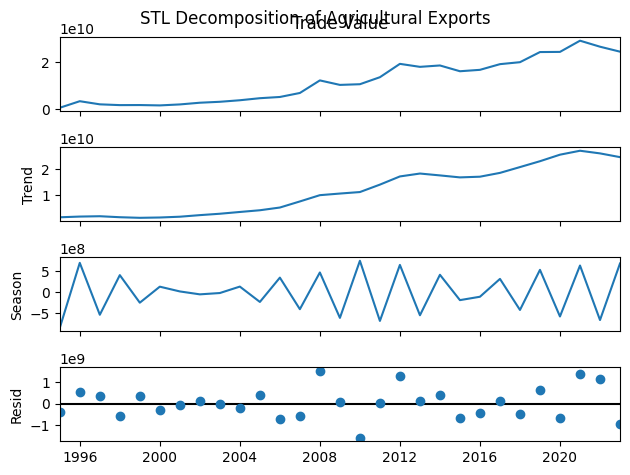

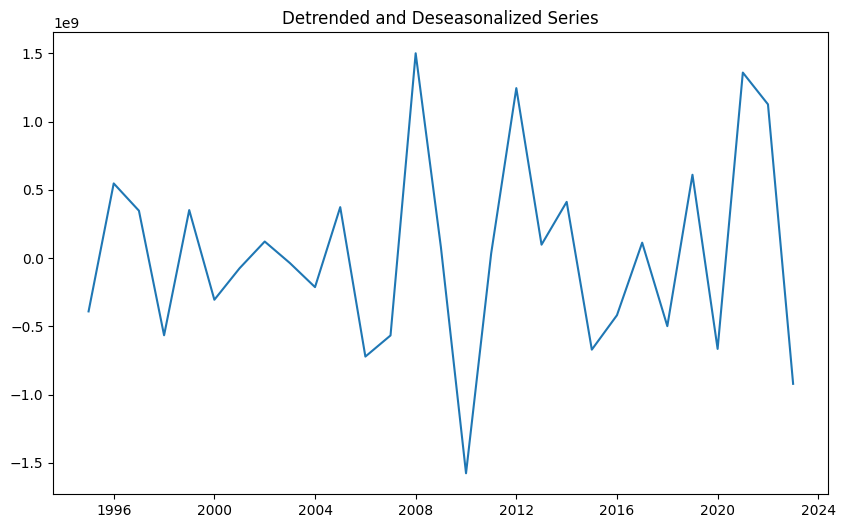

ADF Statistic: -6.40954890896558
p-value: 1.9058319647617605e-08
✅ The detrended-deseasonalized series is stationary (reject H0)


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

# --- Step 1: Read your data
# (if you already have yearly_exports_ts loaded, skip this)
# Smooth 2008 drop manually
# Option: Replace 2008 value with average of 2007 and 2009
# yearly_exports_ts.loc['2008'] = (int(yearly_exports_ts.loc['2007']) + int(yearly_exports_ts.loc['2009']) + int(yearly_exports_ts.loc['2010']) + int(yearly_exports_ts.loc['2006'])) / 4

print (yearly_exports_ts.loc['2008'])

# --- Step 2: STL Decomposition (detrend + deseasonalize)
stl = STL(yearly_exports_ts, period=2)  # Period=2 for yearly data
result = stl.fit()

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot to see components
result.plot()
plt.suptitle("STL Decomposition of Agricultural Exports")
plt.show()

# --- Step 3: Remove trend and seasonality
# Detrended & Deseasonalized series = residual
detrended_deseasonalized = residual

# Plot residuals (should look more stationary)
plt.figure(figsize=(10,6))
plt.plot(detrended_deseasonalized)
plt.title("Detrended and Deseasonalized Series")
plt.show()

# --- Step 4: Test for Stationarity (ADF Test)
adf_result = adfuller(detrended_deseasonalized.dropna())

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

if adf_result[1] < 0.05:
    print('✅ The detrended-deseasonalized series is stationary (reject H0)')
else:
    print('⚠️ The series is still non-stationary (fail to reject H0)')


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -626.055
Date:                Sat, 26 Apr 2025   AIC                           1258.110
Time:                        18:11:01   BIC                           1262.212
Sample:                    01-01-1995   HQIC                          1259.395
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2977      0.242     -1.228      0.219      -0.773       0.177
ma.L2         -0.6417      0.272     -2.357      0.018      -1.175      -0.108
sigma2      3.965e+17        nan        nan        n

/Users/sandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

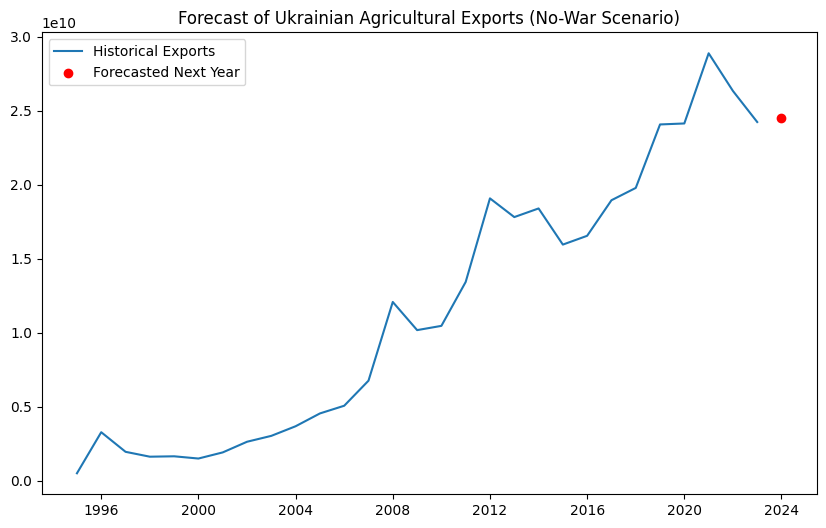

In [42]:
from pmdarima import auto_arima

# --- Step 1: Fit ARIMA model to residuals (stationary)
model_residuals = auto_arima(detrended_deseasonalized.dropna(), seasonal=False, stepwise=True, suppress_warnings=True)

# Print model summary
print(model_residuals.summary())

# --- Step 2: Forecast the next residual
forecast_residual = model_residuals.predict(n_periods=1)[0]
print(f"Forecasted Residual: {forecast_residual}")

# --- Step 3: Forecast Trend and Seasonal components separately

# Extend trend: assume continuation of last value or small drift
last_trend = trend.iloc[-1]
forecast_trend = last_trend  # or extrapolate linearly if you want

# Extend seasonal: simply repeat seasonal pattern
last_seasonal = seasonal.iloc[-1]
forecast_seasonal = last_seasonal  # or repeat the last seasonal value

# --- Step 4: Rebuild the final forecast
forecast_final = forecast_trend + forecast_seasonal + forecast_residual
print(f"Predicted Export Value for Next Year: {forecast_final}")

# --- Optional: Plot
next_year = yearly_exports_ts.index[-1] + pd.DateOffset(years=1)

# Plot
plt.figure(figsize=(10,6))
plt.plot(yearly_exports_ts, label="Historical Exports")
plt.scatter([next_year], [forecast_final], color='red', label="Forecasted Next Year")
plt.legend()
plt.title("Forecast of Ukrainian Agricultural Exports (No-War Scenario)")
plt.show()



/Users/sandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -626.055
Date:                Sat, 26 Apr 2025   AIC                           1258.110
Time:                        18:14:52   BIC                           1262.212
Sample:                    01-01-1995   HQIC                          1259.395
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2977      0.242     -1.228      0.219      -0.773       0.177
ma.L2         -0.6417      0.272     -2.357      0.018      -1.175      -0.108
sigma2      3.965e+17        nan        nan        n

/Users/sandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


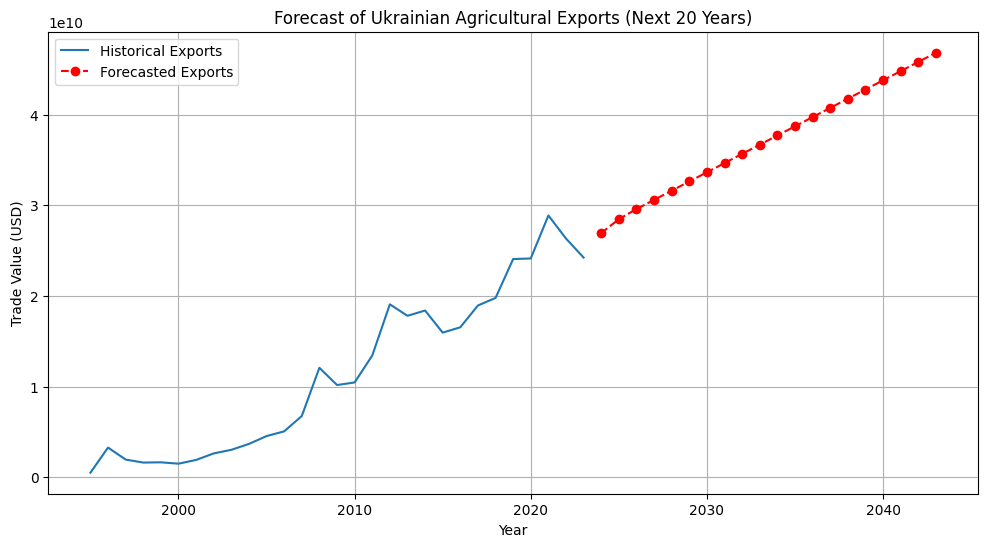

            Year  Forecasted Export Value
2024-01-01  2024             2.693903e+10
2025-01-01  2025             2.846949e+10
2026-01-01  2026             2.958704e+10
2027-01-01  2027             3.060214e+10
2028-01-01  2028             3.161725e+10
2029-01-01  2029             3.263235e+10
2030-01-01  2030             3.364745e+10
2031-01-01  2031             3.466256e+10
2032-01-01  2032             3.567766e+10
2033-01-01  2033             3.669276e+10
2034-01-01  2034             3.770787e+10
2035-01-01  2035             3.872297e+10
2036-01-01  2036             3.973807e+10
2037-01-01  2037             4.075318e+10
2038-01-01  2038             4.176828e+10
2039-01-01  2039             4.278338e+10
2040-01-01  2040             4.379849e+10
2041-01-01  2041             4.481359e+10
2042-01-01  2042             4.582869e+10
2043-01-01  2043             4.684380e+10


In [44]:
from pmdarima import auto_arima

# --- Step 1: Fit ARIMA model to residuals (stationary)
model_residuals = auto_arima(detrended_deseasonalized.dropna(), seasonal=False, stepwise=True, suppress_warnings=True)

# Print model summary
print(model_residuals.summary())

# --- Step 2: Forecast the next n residuals
n_years = int(input("Enter the number of years to forecast: "))

forecasted_residuals = model_residuals.predict(n_periods=n_years)

# --- Step 3: Forecast Trend and Seasonal components separately
# Extend trend and seasonal components

# Forecast trend: assume constant (or you could add extrapolation later)
from sklearn.linear_model import LinearRegression
import numpy as np

# Fit linear regression to trend
X = np.arange(len(trend)).reshape(-1, 1)
y = trend.values
trend_model = LinearRegression().fit(X, y)

# Forecast future trend
X_future = np.arange(len(trend), len(trend) + n_years).reshape(-1, 1)
forecasted_trend = trend_model.predict(X_future)

# Forecast seasonal: assume repeating the last seasonal value
last_seasonal = seasonal.iloc[-1]
forecasted_seasonal = np.full(n_years, last_seasonal)  # repeat the last seasonal value

# --- Step 4: Rebuild the final forecast
forecast_final = forecasted_trend + forecasted_seasonal + forecasted_residuals

# --- Step 5: Build forecasted index (dates)
future_years = pd.date_range(start=yearly_exports_ts.index[-1] + pd.DateOffset(years=1), 
                             periods=n_years, 
                             freq='YS')  # YS = Year Start

# --- Step 6: Plot
plt.figure(figsize=(12,6))
plt.plot(yearly_exports_ts, label="Historical Exports")
plt.plot(future_years, forecast_final, 'ro--', label="Forecasted Exports")
plt.legend()
plt.title(f"Forecast of Ukrainian Agricultural Exports (Next {n_years} Years)")
plt.xlabel('Year')
plt.ylabel('Trade Value (USD)')
plt.grid(True)
plt.show()

# --- Optional: Print the forecasted values
forecast_df = pd.DataFrame({
    'Year': future_years.year,
    'Forecasted Export Value': forecast_final
})
print(forecast_df)


In [47]:
pre_war_avg = yearly_exports_ts.loc['2019':'2021'].mean()
war_avg = yearly_exports_ts.loc['2022':'2023'].mean()

# How much did exports drop?
impact_factor = war_avg / pre_war_avg /2
print(f"Impact Factor (war vs pre-war): {impact_factor}")


Impact Factor (war vs pre-war): 0.49198436461292816


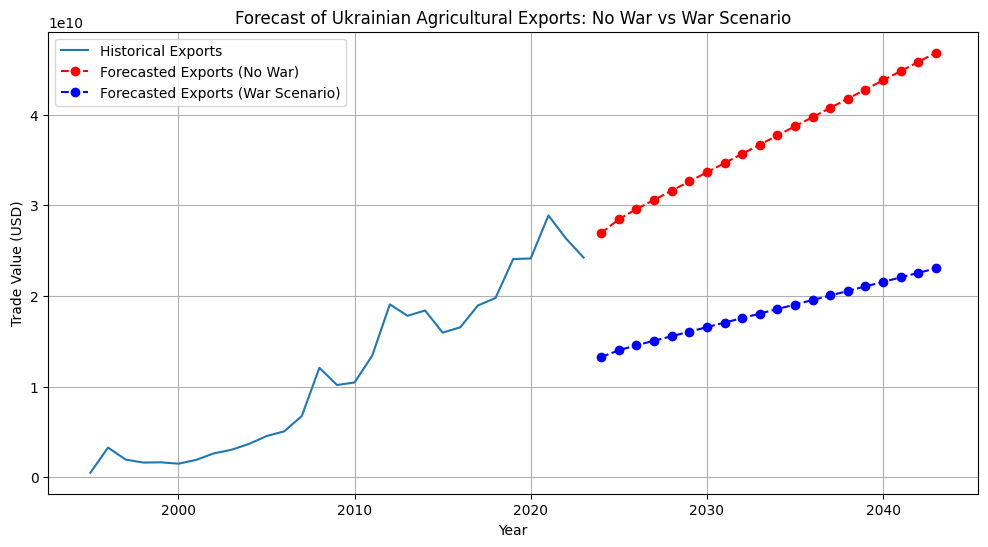

In [48]:
forecast_final_war = forecast_final * impact_factor
plt.figure(figsize=(12,6))
plt.plot(yearly_exports_ts, label="Historical Exports")
plt.plot(future_years, forecast_final, 'ro--', label="Forecasted Exports (No War)")
plt.plot(future_years, forecast_final_war, 'bo--', label="Forecasted Exports (War Scenario)")
plt.legend()
plt.title("Forecast of Ukrainian Agricultural Exports: No War vs War Scenario")
plt.xlabel('Year')
plt.ylabel('Trade Value (USD)')
plt.grid(True)
plt.show()
# Assume linear recovery: back to 90% of pre-war trend after 10 years
recovery_years = np.linspace(impact_factor, 0.9, n_years)
forecast_final_war = forecast_final * recovery_years
